In [34]:
import numpy as np 
import pandas as pd 
import networkx as nx 
import matplotlib as pyplot 
from collections import defaultdict 
import pore_tool as pt 
from math import ceil
import yaml
from yaml.loader import SafeLoader

#TODO Write out a combo of 27 cells with particles and pores as spheres in different colors 


print("read data...")
fdir = "example_data/biogel/positions.xyz" 
df_pos = pd.read_csv(fdir, delim_whitespace=True, names=["type,",'x','y','z'])
pos = df_pos[['x','y','z']].values 

print("initialize variables...")
with open('param_pore_biogel.yaml') as f:
    param = yaml.load(f, Loader=SafeLoader)

ndim = int(param['dimension'])

# generate particles object 
sigma= float(param['sigma'])
particles = pt.Spheres(pos,ndim,sigma)

# generate box object 
lx = 30 
origin = (-15)*np.ones(ndim)
box = pt.Box(origin,lx,ndim)

# initalize cells object
# absolute lmin = particles.sigma 
lmin = 3*particles.sigma 
cells = pt.Cells(lmin,box.lx,ndim)

# initialize voxels object
voxcels_per_cell = int(param['voxcels_per_cell'])
vxl = cells.lx/voxcels_per_cell
vxn = cells.nx*voxcels_per_cell 
voxcels = pt.Voxcels(vxl,vxn, box.origin,ndim)

print("generate cell lists...")
# initalize cells object 
cells.list_generate(particles.pos,voxcels.coords, voxcels.pos, box.origin)

N_trial = int(param['N_trial'])
threshold_overlap = float(param['threshold_overlap'])

print("calculate voxcel state...")
for ci in cells.coords:

    vcoords = cells.voxcel_list[ci]
    pcoords = []
    neighbours = cells.get_neighbour_coords(ci)
    for nci in neighbours:
        pcoords.extend(cells.particle_list[nci])

    if pcoords:
        pos_v = np.array([voxcels.pos[i] for i in vcoords])
        pos_c = particles.pos[pcoords]
        dist, ndist = pt.get_vdistance(pos_v, pos_c, box.lx)

        for i, j in np.argwhere(ndist < (particles.outer_radius+voxcels.outer_radius)):
            overlap_volume_i = particles.estimate_volume(
                voxcels, vcoords[i], pcoords[j], box.lx, N_trial)
            if overlap_volume_i > threshold_overlap:
                voxcels.set_to_filled(vcoords[i])

print("generate links between empty voxcels...")
voxcels.get_links()



read data...
initialize variables...
generate cell lists...
calculate voxcel state...
generate links between empty voxcels...


In [36]:
G = nx.Graph()
G.add_edges_from(voxcels.links)



In [37]:
dlist=list(G.degree())
degrees = [ item[1] for item in dlist]


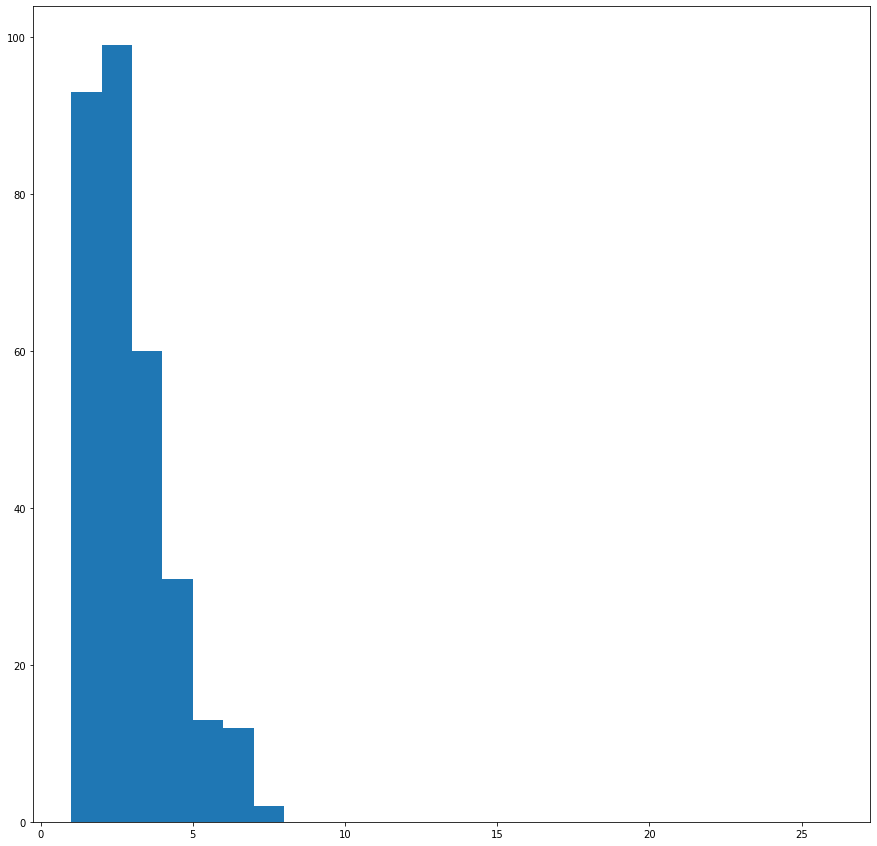

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
plt.hist(degrees, bins=np.arange(1,27))
plt.show()


In [39]:
domains = list(nx.connected_components(G))
domain_lengths = np.array([len(domain) for domain in domains])
pore_volumes = voxcels.volume*domain_lengths
print(domain_lengths)

[ 2 12 11  2  2  4  6 10  2  6  3  4  2  2  4  5  2  3  3  2  2  3  2 12
  4  6 17  3  2  7  2  2  3  2  4  2  2  2 14  6 16  3  3  2  2 20  4  2
  2 17 10  2  9  3  3  3  4  2  4  2  4  3  4  2]


In [26]:
remove = [node for node,degree in dict(G.degree()).items() if degree < 10]
print(remove)
G.remove_nodes_from(remove)

[(59, 59, 8), (1, 0, 11), (0, 0, 36), (59, 0, 35), (1, 0, 37), (0, 0, 39), (2, 59, 17), (2, 1, 37), (3, 59, 18), (3, 59, 19), (3, 0, 19), (4, 59, 18), (4, 1, 30), (4, 1, 44), (5, 0, 14), (5, 1, 27), (3, 1, 38), (3, 1, 40), (5, 0, 48), (5, 0, 16), (6, 1, 16), (5, 59, 18), (6, 0, 33), (6, 1, 45), (6, 59, 46), (7, 59, 9), (7, 59, 17), (8, 0, 17), (8, 0, 40), (7, 0, 49), (8, 0, 48), (6, 1, 50), (7, 1, 48), (7, 59, 51), (8, 59, 16), (9, 0, 17), (8, 0, 27), (9, 1, 33), (10, 0, 17), (10, 59, 48), (10, 0, 48), (10, 59, 51), (9, 59, 15), (11, 0, 46), (10, 59, 47), (12, 0, 1), (12, 59, 1), (12, 0, 2), (12, 59, 6), (13, 0, 44), (14, 0, 24), (14, 1, 24), (14, 59, 40), (15, 0, 30), (15, 0, 57), (15, 1, 58), (15, 0, 1), (16, 0, 1), (16, 1, 7), (16, 1, 9), (17, 0, 3), (17, 59, 30), (17, 59, 31), (17, 1, 35), (17, 1, 56), (17, 59, 59), (18, 59, 59), (18, 59, 0), (18, 59, 1), (18, 1, 32), (18, 59, 52), (18, 59, 53), (18, 1, 55), (17, 0, 58), (18, 59, 58), (17, 1, 58), (18, 1, 58), (19, 0, 6), (17, 1, 4

In [27]:
domains = list(nx.connected_components(G))
domain_lengths = np.array([len(domain) for domain in domains])
pore_volumes = voxcels.volume*domain_lengths


In [28]:
domain_lengths

array([126285])

In [ ]:
   
outfile = param['outfile']
with open(outfile, 'w') as f:
    for v, d in zip(pore_volumes, domain_lengths):
        f.write("{},{}\n".format(v, d))

N_empty = np.sum(domain_lengths)
n=0
with open('voxcels_biogel.xyz','w') as f:
    f.write("{}\n".format(N_empty))
    f.write("Voxcels for biogel (cubes)\n")
    for ci in cells.coords:
        vcoords = cells.voxcel_list[ci]
        for vi in vcoords: 
            if voxcels.fill_state[vi] == 0:
                n+=1 
                #pos = voxcels.pos[vi] 
                vertices = voxcels.get_vertices(vi)
                #lprint(vertices)
                for vert in vertices:
                    f.write("V   {}   {}   {}\n".format(vert[0],vert[1],vert[2]))


